# SIT796 Task 8.1HD
Practical Reinforcement Learning

Brenton Adey
222165064

## Towards Physically Safe Reinforcement Learning under Supervision

---

In [8]:
# Import the libaries
import os
import copy
import random
import glob
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np

# Note that the code has been updated to support the new gymnasium library over gym
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from gymnasium.utils.save_video import save_video

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import Video, clear_output

# Setup the seed and Torch to deterministic
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [9]:
# Make folders for videos and artifacts
videos_path = "./videos"
if not os.path.exists(videos_path):
    os.makedirs(videos_path)

# Environment

Here we use the `ActionNormalizer` routine as an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [10]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high
        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor
        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)
     
        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

With the `ActionNormalizer` routine defined above, we can initialise the environment as follows

In [11]:
env_id = 'InvertedPendulum-v4'
print("Current config is:")
print(env_id)
env = gym.make(env_id, render_mode="rgb_array_list")
env = ActionNormalizer(env)

Current config is:
InvertedPendulum-v4


# Deep Deterministic Policy Gradient (DDPG) Supervisor

## Replay Buffer

In [121]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.
A **Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.


In [13]:
class OUNoise:
    """Ornstein-Uhlenbeck process routine"""

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

## Soft update target network

Since the network $Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. 

Thus, the target network is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively. These are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

This greatly improves the stability of learning.

Here, we use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [14]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()
        
        return action
    
    
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

## Implementation and Results

We now proceed to implent the DDPG agent. The structure of the agent and its interactions with the environment as shown in the diagram below as depicted in *F. Li et al. (2019), Manipulation Skill Acquisition for Robotic Assembly Based on Multi-Modal Information Description. IEEE Access*. The paper can found at: https://ieeexplore.ieee.org/abstract/document/8793056

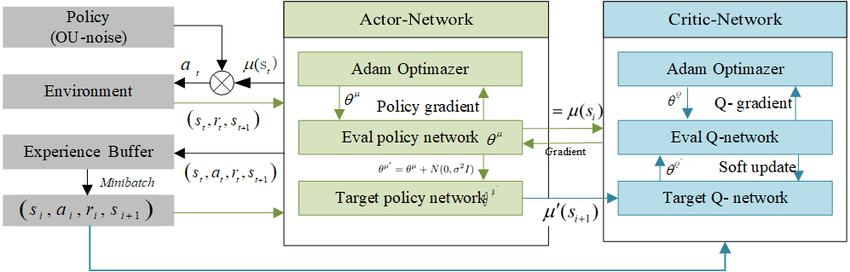

 To implement the agent, we use a number of routines to select the actions, step, update the model and do the updating of the network. These routines are the following


| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [25]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
    """
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
            ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.step_counter = 0
                
        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0
        self.total_epochs = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
        
        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        self.step_counter +=1
        
        if not self.is_test:
            self.transition += [reward, next_state, terminated]
            self.memory.store(*self.transition)
        
        return next_state, reward, terminated, truncated
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        
        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
                
        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, terminated, truncated = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if terminated or truncated:         
                state, _ = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )
                
        return scores, actor_losses, critic_losses
        
    def test(self, video_folder, video_name_prefix):
        """Test the agent."""
        
        self.is_test = True

        state, _ = self.env.reset()
        done = False
        score = 0
        previous_step_counter = self.step_counter
        
        while not done:
            action = self.select_action(state)
            next_state, reward, terminated, truncated = self.step(action)

            state = next_state
            score += reward

            done = terminated | truncated
        
        save_video(
            self.env.render(),
            video_folder=video_folder,
            name_prefix=video_name_prefix,
            fps = self.env.metadata["render_fps"],
            step_trigger=lambda x: x==previous_step_counter,
            step_starting_index=previous_step_counter
        )

        video_location = f"{video_folder}/{video_name_prefix}-step-{previous_step_counter}.mp4"
        print(f"Video successfuly saved at: {video_location}\n")
        print("Score: ", score)
        
        return score, video_location
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

### Method Parameters

In [26]:
num_frames = 50000 #@param {type:"integer"}
memory_size = 100000 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}
ou_noise_theta = 1.0 #@param {type:"number"}
ou_noise_sigma = 0.1 #@param {type:"number"}
initial_random_steps = 10000 #@param {type:"integer"}

In [27]:
# parameters
agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps
)

cpu


In [28]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 42
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

With all the routines defined as above, we can try our agent on the pendulum. To do this, we train it for a single step. This effectively initialises the agent but does not allow it to trian. We can then use this agent to see how the untrained agent fairs as a baseline.

In [29]:
# Test the untrained agent
video_folder = "videos"
video_name_prefix = "ddpq"

score, video_location = agent.test(video_folder,video_name_prefix)

# Show the video
Video(video_location, embed=True)

Moviepy - Building video /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/ddpq-step-0.mp4.
Moviepy - Writing video /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/ddpq-step-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/ddpq-step-0.mp4
Video successfuly saved at: videos/ddpq-step-0.mp4

Score:  20.0


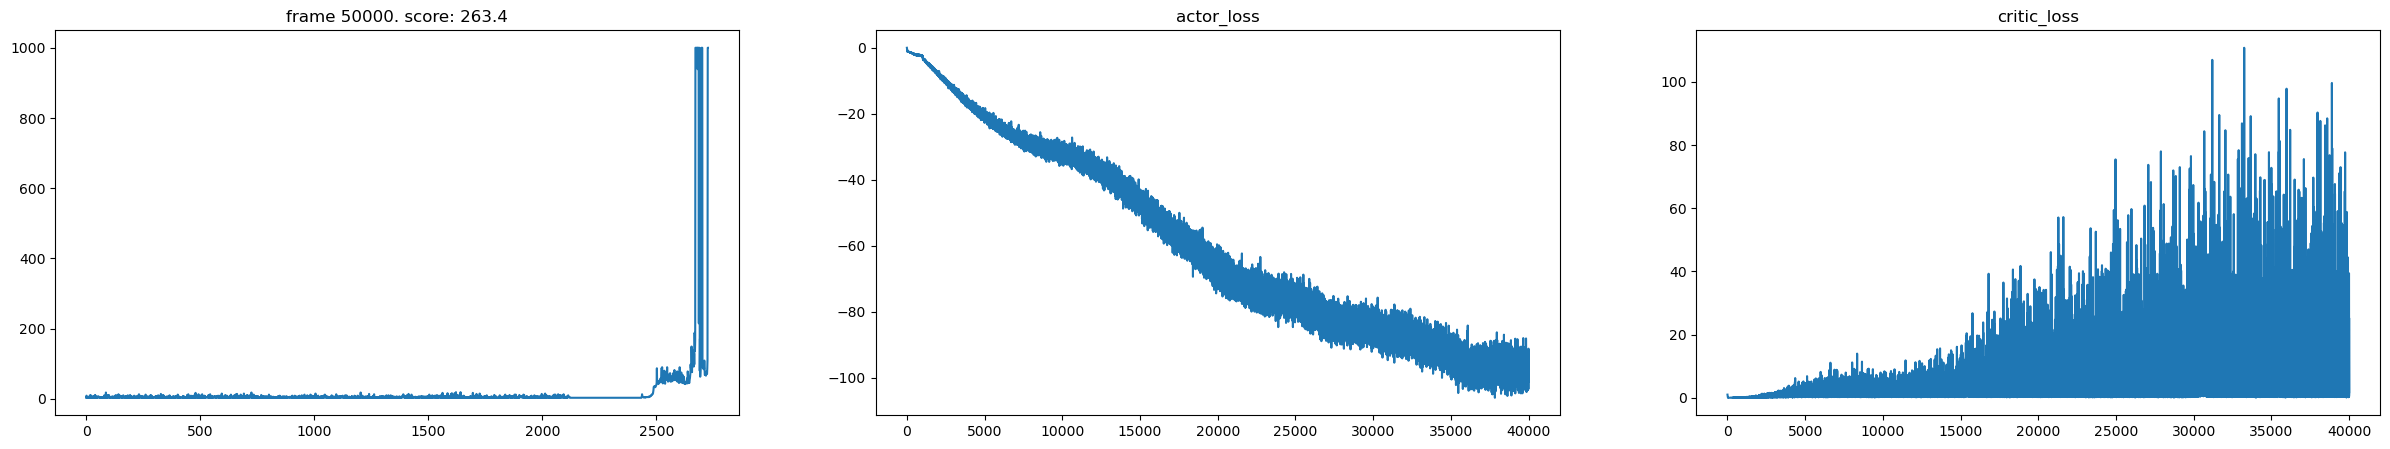

In [30]:
agent.train(num_frames)

In [31]:
# Test the trained agent
video_folder = "videos"
video_name_prefix = "ddpq"

score = agent.test(video_folder,video_name_prefix)


# Show the video
files = sorted(glob.glob(f'{video_folder}/{video_name_prefix}*.mp4'))
Video(files[-1], embed=True)

Moviepy - Building video /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/ddpq-step-50020.mp4.
Moviepy - Writing video /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/ddpq-step-50020.mp4



Moviepy - Done !
Moviepy - video ready /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/ddpq-step-50020.mp4
Video successfuly saved at: videos/ddpq-step-50020.mp4

Score:  1000.0


# DDPG with Supervisor Algorithm

In [138]:
class SupervisedDDPGAgent:
    """SupervisedDDPGAgent interacting with environment.
    """
    def __init__(
        self,
        env: gym.Env,
        supervisor_policy: Actor,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
            ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        
        self.env = env
        # Specific to pioneer based supervised DDPG
        self.supervisor_policy = supervisor_policy
        self.memory_size = memory_size
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.priority_memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.temp_memory = ReplayBuffer(obs_dim, memory_size, batch_size)

        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.step_counter = 0

        # Initialise k factor for combining actors
        self.k = 1
                
        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        self.pioneer = Actor(obs_dim, action_dim).to(self.device)

        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.pioneer_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            supervisor_action = self.supervisor_policy(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
            
            learning_actor_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()

            selected_action = self.k*supervisor_action + (1-self.k)*learning_actor_action
        
        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        self.step_counter +=1
        
        if not self.is_test:
            self.transition += [reward, next_state, terminated]
            self.memory.store(*self.transition)
            self.temp_memory.store(*self.transition)
        
        return next_state, reward, terminated, truncated
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        
        # train critic (remains the same as DDPG)
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
                
        # train actor ----(this needs to be updated by adding the differant between actor (or target actor?) and supervisor to gradient)----
        # Note that self.k*(self.supervisor_policy(state)) is a constant and
        # hence reduces to 0 in the chain rule expanded form in the paper.
        # Used `-value` as we want to maximize the value given
        actor_loss = -self.critic(
            state,
            self.k*(self.supervisor_policy(state))+(1-self.k)*self.actor(state)
            ).mean()
        
        supervisor_loss = 0.5*F.mse_loss(self.actor(state),self.supervisor_policy(state))

        combined_loss = actor_loss + self.k*supervisor_loss
        
        self.actor_optimizer.zero_grad()
        combined_loss.backward()
        self.actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data

    def update_pioneer(self):
        """Update the pioneer by gradient descent."""
        device = self.device  # for shortening the following lines
        
        # Try get a batch, but if not enough samples have been made, pick all
        try:
            samples = self.priority_memory.sample_batch()
        except ValueError:
            end_idx = len(self.priority_memory)
            samples = dict(obs=self.priority_memory.obs_buf[:end_idx],
                    next_obs=self.priority_memory.next_obs_buf[:end_idx],
                    acts=self.priority_memory.acts_buf[:end_idx],
                    rews=self.priority_memory.rews_buf[:end_idx],
                    done=self.priority_memory.done_buf[:end_idx])
        state = torch.FloatTensor(samples["obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
                
        # Train pioneer
        pioneer_loss = 0.5*F.mse_loss(self.pioneer(state),action)
        
        self.pioneer_optimizer.zero_grad()
        pioneer_loss.backward()
        self.pioneer_optimizer.step()
        
    
    def train(
            self,
            target_score: int,
            k_decrease_factor: float,
            k_min: float,
            pioneer_update_frequency: int,
            pioneer_buffer_threshold: int,
            pioneer_buffer_increase_amount: int,
            num_frames: int,
            plotting_interval: int = 200
            ):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        num_good_episodes = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, terminated, truncated = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if terminated or truncated:         
                state, _ = self.env.reset()
                scores.append(score)
                if score >= pioneer_buffer_threshold:
                    # Copy temp buffer into priority buffer
                    # Make next lines shorter
                    temp_mem = self.temp_memory
                    start_index = self.priority_memory.ptr
                    end_index = min(start_index+len(temp_mem),self.priority_memory.max_size)

                    self.priority_memory.obs_buf[start_index:end_index] = temp_mem.obs_buf[:len(temp_mem)]
                    self.priority_memory.next_obs_buf[start_index:end_index] = temp_mem.next_obs_buf[:len(temp_mem)]
                    self.priority_memory.acts_buf[start_index:end_index] = temp_mem.acts_buf[:len(temp_mem)]
                    self.priority_memory.rews_buf[start_index:end_index] = temp_mem.rews_buf[:len(temp_mem)]
                    self.priority_memory.done_buf[start_index:end_index] = temp_mem.done_buf[:len(temp_mem)]
                    self.priority_memory.ptr = (start_index + len(temp_mem)) % self.priority_memory.max_size
                    self.priority_memory.size = min(self.priority_memory.size + len(temp_mem), self.priority_memory.max_size)

                # Copy the learning network to the pioneer
                self.pioneer.load_state_dict(self.actor.state_dict())
                # Sample transaction from prioritised buffer
                self.update_pioneer()
                
                # Clear temporary memory
                self.temp_memory = ReplayBuffer(
                    env.observation_space.shape[0],
                    self.memory_size,
                    self.batch_size
                    )
                
                # If the episode beat the target score, add to the counter
                if score >= target_score:
                    num_good_episodes +=1
                else:
                    num_good_episodes = 0
                
                # If the number of good episodes in a row is met, decrease k
                if num_good_episodes>=pioneer_update_frequency and self.k>k_min:
                    self.k *= k_decrease_factor
                    # Re-initialize the learning network
                    self.actor.load_state_dict(self.pioneer.state_dict())
                    # Increase pioneer_buffer_threshold
                    pioneer_buffer_threshold += pioneer_buffer_increase_amount
                
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )
        return scores, actor_losses, critic_losses
        
    def test(self, video_folder, video_name_prefix):
        """Test the agent."""
        
        self.is_test = True

        state, _ = self.env.reset()
        done = False
        score = 0
        previous_step_counter = self.step_counter
        
        while not done:
            action = self.select_action(state)
            next_state, reward, terminated, truncated = self.step(action)

            state = next_state
            score += reward

            done = terminated | truncated
        
        save_video(
            self.env.render(),
            video_folder=video_folder,
            name_prefix=video_name_prefix,
            fps = self.env.metadata["render_fps"],
            step_trigger=lambda x: x==previous_step_counter,
            step_starting_index=previous_step_counter
        )

        print("Video successfuly saved.\n")
        print("Score: ", score)
        
        return score
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [139]:
supervised_agent = SupervisedDDPGAgent(
    env,
    agent.actor, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=batch_size
)

cpu


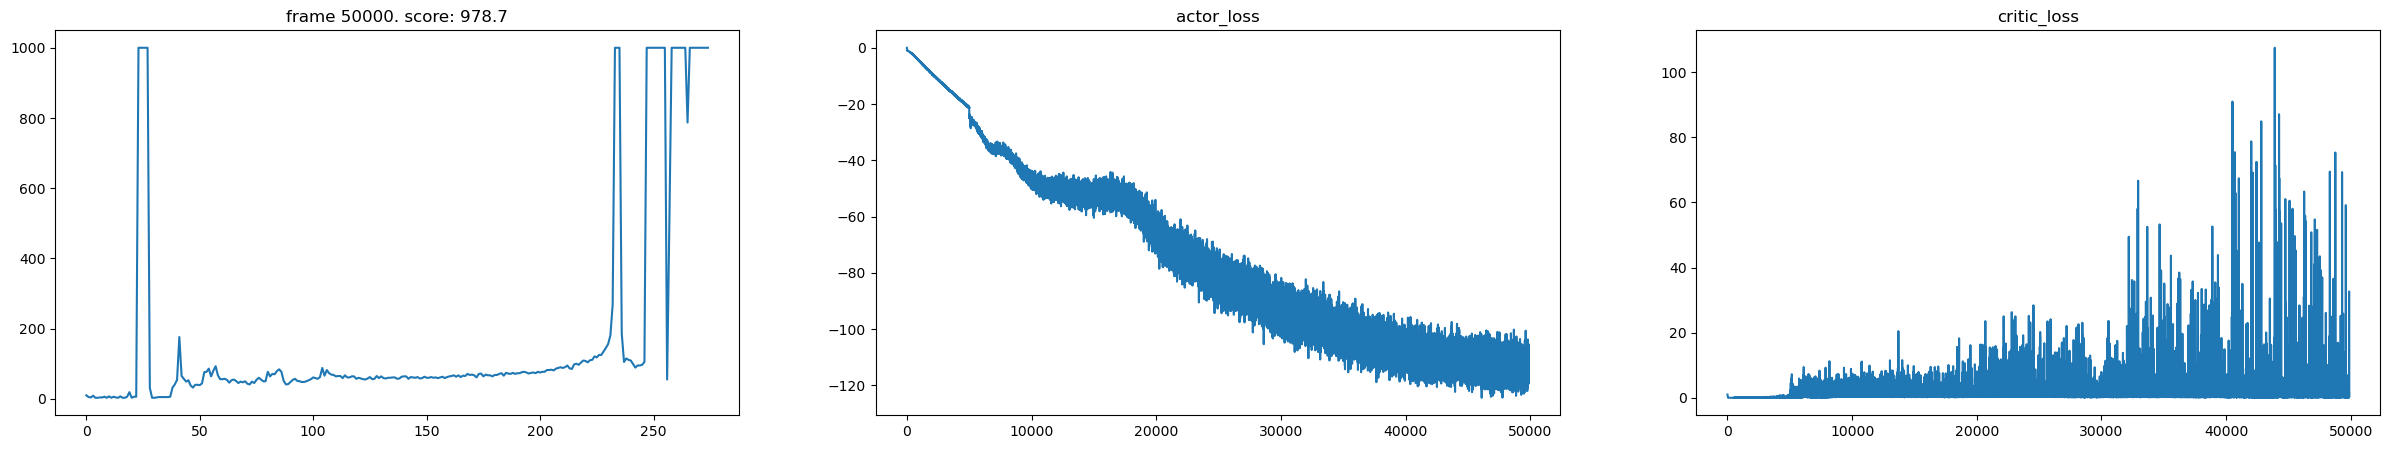

([10.0,
  5.0,
  4.0,
  9.0,
  3.0,
  3.0,
  4.0,
  4.0,
  6.0,
  3.0,
  7.0,
  3.0,
  6.0,
  4.0,
  3.0,
  7.0,
  3.0,
  3.0,
  6.0,
  19.0,
  3.0,
  6.0,
  6.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  31.0,
  3.0,
  3.0,
  4.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  6.0,
  32.0,
  41.0,
  54.0,
  176.0,
  65.0,
  57.0,
  49.0,
  53.0,
  38.0,
  32.0,
  40.0,
  40.0,
  39.0,
  44.0,
  76.0,
  77.0,
  86.0,
  64.0,
  80.0,
  93.0,
  67.0,
  56.0,
  56.0,
  57.0,
  54.0,
  46.0,
  53.0,
  55.0,
  51.0,
  45.0,
  49.0,
  47.0,
  50.0,
  43.0,
  41.0,
  49.0,
  45.0,
  54.0,
  60.0,
  55.0,
  50.0,
  50.0,
  77.0,
  64.0,
  71.0,
  70.0,
  79.0,
  84.0,
  77.0,
  51.0,
  41.0,
  42.0,
  48.0,
  54.0,
  57.0,
  51.0,
  50.0,
  48.0,
  48.0,
  50.0,
  53.0,
  56.0,
  61.0,
  59.0,
  57.0,
  62.0,
  88.0,
  66.0,
  82.0,
  73.0,
  69.0,
  68.0,
  64.0,
  65.0,
  65.0,
  59.0,
  67.0,
  61.0,
  61.0,
  64.0,
  64.0,
  57.0,
  60.0,
  58.0,
  56.0,
  55.0,
  58.0,
  62.0,
  56.0,
  5

In [140]:
scores, actor_losses, critic_losses = supervised_agent.train(950,0.1, 0.01, 5, 200, 10, num_frames)

In [141]:
# Test the trained agent
video_folder = "videos"
video_name_prefix = "supervised-ddpq"

score = agent.test(video_folder,video_name_prefix)


# Show the video
files = sorted(glob.glob(f'{video_folder}/{video_name_prefix}*.mp4'))
Video(files[-1], embed=True)

Moviepy - Building video /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/supervised-ddpq-step-51020.mp4.
Moviepy - Writing video /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/supervised-ddpq-step-51020.mp4



Moviepy - Done !
Moviepy - video ready /Users/brenton/Library/CloudStorage/OneDrive-Personal/Documents/_UNIVERSITY/_MASTEROFAI/2023Tri1/SIT796 Reinforcement Learning/8/SIT798-Task8-1HD/videos/supervised-ddpq-step-51020.mp4
Video successfuly saved at: videos/supervised-ddpq-step-51020.mp4

Score:  1000.0


# Experiments

## Train good supervision
In conjunction with the experiments discussed in the paper, we will first need to train a good supervisor capable of achieving rewards over 950.

As specified, we will do this with the DDPG algorithm